In [7]:
import pathlib
import platform

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import pymc3 as pm

import arviz as ar
import matplotlib.pyplot as pl
from matplotlib import rcParams
import seaborn as sb

### <u>Package Versions<u>

In [8]:
def pkg_ver(pkgs):
    print('Python & Package Versions')
    print('----------------')
    print(f'PYTHON: {platform.python_version()}')
    for pki in pkgs:
        print(f'{pki.__name__}: {pki.__version__}')
pkg_ver([np, pd, pm, ar, sb])

Python & Package Versions
----------------
PYTHON: 3.7.3
numpy: 1.17.3
pandas: 0.25.0
pymc3: 3.7
arviz: 0.5.1
seaborn: 0.9.0


In [9]:
ar.style.use('arviz-darkgrid')

### <u>Overview</u>

In this and [a subsequent notebook](), I implement bayesian regression models to predict chlorophyll from satellite and ancillary data. I use a Bayesian framework for all models. For each model, implementation follows the sequence below.

* The model is cast in a Bayesian framework using a probabilistic programming language (PPL);
* A set of prior predictive simulations is conducted to ascertain that model priors are reasonable;
* The model is fit using the No U-Turn Sampler (NUTS) variant of Hamiltonian Monte Carlo, and the data subset from NOMAD 2008;
* Model predictive skill and  uncertainty are quantified via posterior distribution evaluation and posterior predictive simulation.

In a [third notebook](), the skill of the models are compared using Information Criteria (IC) based methods. These include Watanabe Akaike Information Criterion (WAIC) and/or Pareto Smoothed Importance Sampling Leave-One-Out Cross Validation (LOO).

### <u>The Present Notebook's Linear Models</u>
I include 1. models here:
1. A simple maximum-blue band ratio (*MBR*) regression model.
2. An OC4-type \\(4^{th}\\)degree polynomial regression.
3. An OCI-type mixture model where one of either OC4-type or Color Index Model is applied to the data.
$$$$

### <u>Loading the Data</u>
The data was stored previously in a [pandas dataframe](https://pandas.pydata.org). 

In [10]:
df = pd.read_pickle('./PickleJar/df_main_2_w_CI.pkl')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Data columns (total 26 columns):
id                4459 non-null int64
etopo2            4459 non-null float64
log_etopo2        4459 non-null float64
lat               4459 non-null float64
rrs411            4293 non-null float64
log_rrs411        4293 non-null float64
rrs443            4456 non-null float64
log_rrs443        4456 non-null float64
rrs489            4422 non-null float64
log_rrs489        4422 non-null float64
rrs510            3435 non-null float64
log_rrs510        3435 non-null float64
rrs555            3255 non-null float64
log_rrs555        3255 non-null float64
rrs670            1598 non-null float64
log_rrs670        1598 non-null float64
CI                1163 non-null float64
CI_OK             4459 non-null int64
MaxBlue           4459 non-null float64
MaxBlueBand       4459 non-null object
MaxBlueBandIdx    4459 non-null int8
mxBlue2Gr         3255 non-null float64
log_mxBlue2Gr     325

### <u>Simple Band Ratio</u>
A. Pooled Model.
A pooled regression model is simply a regression on a the whole dataset without partitioning the data into distinct groups (see Partially Pooled Model section next)

In [12]:
df_small = df[['log_mxBlue2Gr', 'MaxBlueBandIdx', 'log_chlor_a']].dropna()

In [13]:
X_ = df_small.log_mxBlue2Gr.values
y = df_small.log_chlor_a.values
X_s = (X_ - X_.mean()) / X_.std()
y_s = (y - y.mean()) / y.std()
X_poly = np.c_[X_s, np.power(X_s, 2), np.power(X_s, 3), np.power(X_s, 4)]

In [14]:
with pm.Model() as mbr_linear_pooled:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=1)
    σ = pm.Exponential('σ', 1)
    μ = α + β * X_s
    likelihood = pm.Normal('likelihood', mu=μ, sd=σ, observed=y_s)

In [20]:
mlp_graph = pm.model_to_graphviz(mbr_linear_pooled)
mlp_graph.render(filename='mdl1', directory='./resources', format='png',
                quiet=True)

'./resources/mdl1.png'

In [23]:
with mbr_linear_pooled:
    prior_mlp = pm.sample_prior_predictive()
    trace_mlp = pm.sample(2000, tune=1000)
    post_mlp = pm.sample_posterior_predictive(mlp_trace)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]
100%|██████████| 8000/8000 [00:07<00:00, 1042.72it/s]


In [78]:
del mlp_trace

In [79]:
mlp_struct = ar.from_pymc3(trace=trace_mlp,
                           prior=prior_mlp,
                           posterior_predictive=post_mlp)

In [80]:
def plot_priors(prior_):
    x_idx = np.argsort(X_s)
    mean_prior_y = prior_['likelihood'].mean(axis=0)
    hdi_prior_y = ar.hpd(prior_['likelihood'])
    prior_realizations = prior_['β'][:, None] * X_s + prior_['α'][:, None]
    pl.title('Pooled Linear Model Prior Analysis')
    pl.scatter(X_s[x_idx], y_s[x_idx], color='r', 
               edgecolor='k', 
               label='true', 
               alpha=0.65, zorder=3
              )
    pl.plot(X_s[x_idx], prior_realizations[0, x_idx].T, color='k',
            alpha=0.1, label='prior model realizations')
    pl.plot(X_s[x_idx], prior_realizations[1:, x_idx].T, color='k',
            alpha=0.1,)
    pl.ylabel('log chl (standardized)')
    pl.xlabel('MBR (standardized)')
    pl.legend(loc='upper center');

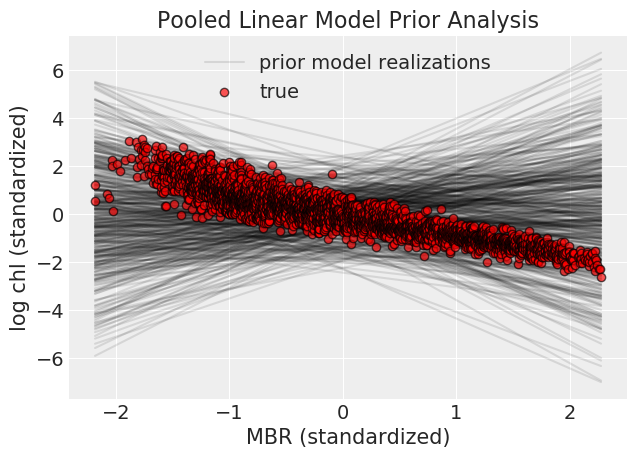

In [81]:
plot_priors(prior_mlp)

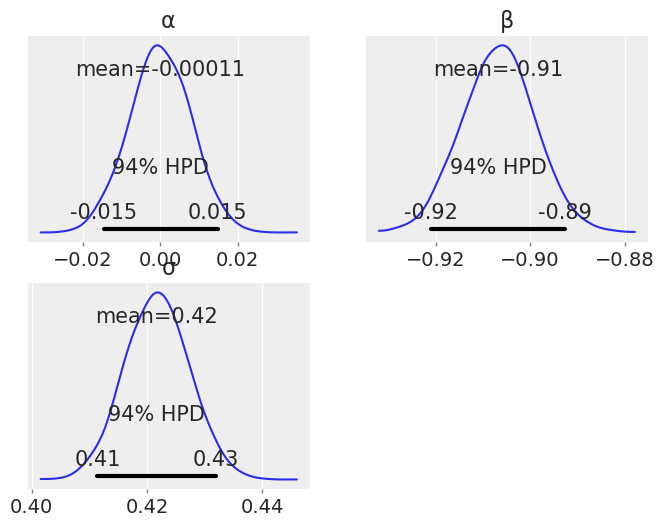

In [89]:
_, ax = pl.subplots(ncols=2, nrows=2, figsize=(8, 6))
ar.plot_posterior(mlp_struct, ax=ax)
ax.ravel()[-1].set_visible(False)

B. Hierarchical, Partially Pooled Model

In [ ]:
with pm.Model() as mbr_linear

---
End of this Notebook